<a href="https://colab.research.google.com/github/medsvs/Project/blob/main/friend_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the no of users in the social network: 3
Enter user ID: 34
Enter user name: medha

Updated Hash Table:
Index 0: []
Index 1: []
Index 2: []
Index 3: []
Index 4: [34]
Index 5: []
Index 6: []
Index 7: []
Index 8: []
Index 9: []
Enter user ID: 42
Enter user name: shanmukha

Updated Hash Table:
Index 0: []
Index 1: []
Index 2: [42]
Index 3: []
Index 4: [34]
Index 5: []
Index 6: []
Index 7: []
Index 8: []
Index 9: []
Enter user ID: 45
Enter user name: srivani

Updated Hash Table:
Index 0: []
Index 1: []
Index 2: [42]
Index 3: []
Index 4: [34]
Index 5: [45]
Index 6: []
Index 7: []
Index 8: []
Index 9: []
Enter user ID 1 for friendship: 42
Enter user ID 2 for friendship: 45
Enter the strength of friendship (1 - self intimacy, 2 - deep friendship, 3 - friends, 4 - casual acquaintances, 5 - strangers): 2
Any more friendships to add (y/n): n


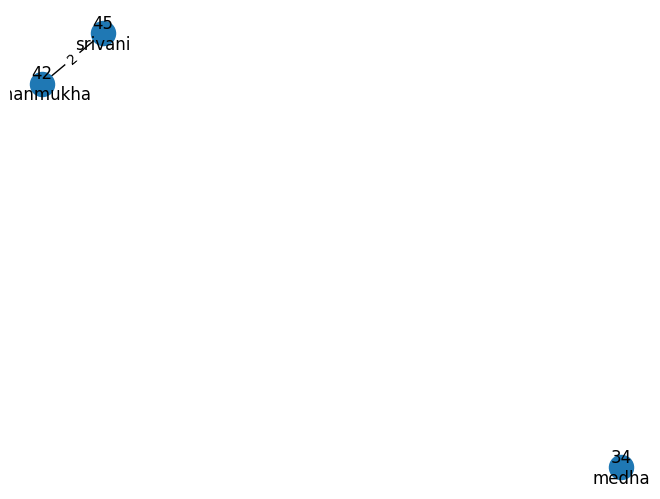


The most influential user is User 42 with PageRank score 0.3333333333333333

Page Ranks of Users:
User ID: 34, Name: medha, Index: 4: 0.05000000000000001
User ID: 42, Name: shanmukha, Index: 2: 0.3333333333333333
User ID: 45, Name: srivani, Index: 5: 0.3333333333333333


KeyboardInterrupt: Interrupted by user

In [1]:
import heapq
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt

class User:
    def __init__(self, user_id, name):
        self.user_id = user_id
        self.name = name
        self.friends = []
        self.index = None  # Added index attribute

    def add_friend(self, friend, weight=1):
        self.friends.append((friend, weight))

    def __str__(self):
        return f"User ID: {self.user_id}, Name: {self.name}, Index: {self.index}"

# Updated hash function
def hash_function(user_id):
    return user_id % 10

# Graph algorithm interface
class GraphAlgorithm:
    def compute_distances(self, graph, start):
        pass

# Dijkstra's algorithm
class Dijkstra(GraphAlgorithm):
    def compute_distances(self, graph, start):
        distances = {node: float('infinity') for node in graph}
        distances[start] = 0
        priority_queue = [(0, start)]

        while priority_queue:
            current_distance, current_node = heapq.heappop(priority_queue)

            if current_distance > distances[current_node]:
                continue

            for neighbor, weight in graph[current_node]:
                distance = current_distance + weight

                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    heapq.heappush(priority_queue, (distance, neighbor))

        return distances

# Jaccard Similarity algorithm
class JaccardSimilarity(GraphAlgorithm):
    def compute_similarity(self, user1, user2):
        set_user1_friends = set(neighbor for neighbor, _ in user1.friends)
        set_user2_friends = set(neighbor for neighbor, _ in user2.friends)

        intersection_size = len(set_user1_friends.intersection(set_user2_friends))
        union_size = len(set_user1_friends.union(set_user2_friends))

        return intersection_size / union_size if union_size != 0 else 0

# PageRank algorithm
def pagerank(graph, damping_factor=0.85, max_iterations=100, tolerance=1e-6):
    num_nodes = len(graph)
    initial_rank = 1 / num_nodes
    ranks = {node: initial_rank for node in graph}

    for _ in range(max_iterations):
        new_ranks = {}
        for node in graph:
            new_rank = (1 - damping_factor) / num_nodes
            new_rank += damping_factor * sum(
                ranks[neighbor] / len(graph[neighbor]) for neighbor, _ in graph[node]
            )
            new_ranks[node] = new_rank

        if all(abs(new_ranks[node] - ranks[node]) < tolerance for node in graph):
            break

        ranks = new_ranks

    return ranks

# Friend recommendation system
class FriendRecommendationSystem:
    def __init__(self, graph_algorithm):
        self.users = {}
        self.graph = {}
        self.graph_algorithm = graph_algorithm
        self.hash_table = {i: [] for i in range(10)}  # Initialize hash_table with 10 indexes

    def add_user(self, user_id, name):
        user = User(user_id, name)
        index = hash_function(user.user_id)

        # Update the hash table
        self.hash_table[index].append(user)

        # Validate the index for uniqueness
        if self.validate_index(index):
            user.index = index
            self.users[user.user_id] = user
            self.graph[user] = user.friends
        else:
            print("Invalid index. User not added.")

        # Display the updated hash table
        print("\nUpdated Hash Table:")
        for idx, users in self.hash_table.items():
            print(f"Index {idx}: {[user.user_id for user in users]}")

    def add_friendship(self, user_id1, user_id2, weight=1):
        user1 = self.users.get(user_id1)
        user2 = self.users.get(user_id2)

        if user1 and user2:
            user1.add_friend(user2, weight)
            user2.add_friend(user1, weight)

    def visualize_graph(self):
        G = nx.Graph()

        for user, friends in self.graph.items():
            G.add_node(user.user_id, label=user.name)

            for friend, weight in friends:
                G.add_edge(user.user_id, friend.user_id, weight=weight)

        pos = nx.spring_layout(G)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw(G, pos, with_labels=True, labels={node: f"{node}\n{G.nodes[node]['label']}" for node in G.nodes})
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()

    def validate_index(self, index):
        # Check if the index is unique among existing users
        return all(existing_user.index != index for existing_user in self.users.values())

    def recommend_friends(self, user_id, num_recommendations=5):
        user = self.users.get(user_id)

        if not user:
            return []

        dijkstra_distances = self.graph_algorithm[0].compute_distances(self.graph, user)
        jaccard_similarity = self.graph_algorithm[1].compute_similarity
        page_ranks = pagerank(self.graph)

        recommendations = []
        for other_user, _ in sorted(page_ranks.items(), key=lambda x: dijkstra_distances[x[0]]):
            if other_user != user and other_user not in user.friends:
                common_friends = set(neighbor for neighbor, _ in user.friends).intersection(
                    set(neighbor for neighbor, _ in other_user.friends)
                )

                if common_friends:
                    common_friend = common_friends.pop()
                    recommendations.append((other_user, common_friend))
                    if len(recommendations) == num_recommendations:
                        break

        return recommendations

    def most_influential_user(self):
        page_ranks = pagerank(self.graph)
        most_influential_user = max(page_ranks, key=page_ranks.get)
        return most_influential_user, page_ranks

# Example usage with user input
system = FriendRecommendationSystem([Dijkstra(), JaccardSimilarity()])

# Add users with safety checks
nu = int(input("Enter the no of users in the social network: "))
for _ in range(nu):
    user_id = int(input("Enter user ID: "))
    name = input("Enter user name: ")
    system.add_user(user_id, name)

# Add friendships
flag = "y"
while (flag.lower() == "y"):
    user_id1 = int(input("Enter user ID 1 for friendship: "))
    user_id2 = int(input("Enter user ID 2 for friendship: "))
    weight = int(input("Enter the strength of friendship (1 - self intimacy, 2 - deep friendship, 3 - friends, 4 - casual acquaintances, 5 - strangers): "))
    system.add_friendship(user_id1, user_id2, weight)
    flag = input("Any more friendships to add (y/n): ")

# Visualize the graph
system.visualize_graph()

# Display the most influential user and page ranks
most_influential_user, page_ranks = system.most_influential_user()
print(f"\nThe most influential user is User {most_influential_user.user_id} with PageRank score {page_ranks[most_influential_user]}")

# Display page ranks of all users
print("\nPage Ranks of Users:")
for user, rank in page_ranks.items():
    print(f"{user}: {rank}")

# Get recommendations
user_id_recommend = int(input("\nEnter user ID for recommendations: "))
num_recommendations = int(input("Enter number of recommendations: "))
recommendations = system.recommend_friends(user_id_recommend, num_recommendations)
print(f"\nFriend recommendations for User {user_id_recommend} based on Dijkstra's distances:")

# Compute Dijkstra's distances for the current user
dijkstra_distances = system.graph_algorithm[0].compute_distances(system.graph, system.users[user_id_recommend])

# Sort recommendations based on Dijkstra's distances
sorted_recommendations = sorted(recommendations, key=lambda x: dijkstra_distances[x[0]])

# Print recommendations with common friend and Dijkstra's distance
for user, common_friend in sorted_recommendations:
    dijkstra_distance = dijkstra_distances[user]

    strength_of_friendship = {1: "self intimacy", 2: "deep friendship", 3: "friends", 4: "casual acquaintances", 5: "strangers"}
    print(f"\nUser {user} has a common friend with User {user_id_recommend}: {common_friend}")
    print(f"Strength of the friendship: {strength_of_friendship[dijkstra_distance]}")
    print(f"Dijkstra's Distance: {dijkstra_distance}")

    # Calculate and print Jaccard similarity
    jaccard_sim = system.graph_algorithm[1].compute_similarity(system.users[user_id_recommend], user)
    print(f"Jaccard Similarity: {jaccard_sim}")

# Display the final hash table
print("\nFinal Hash Table:")
for idx, users in system.hash_table.items():
    print(f"Index {idx}: {None if not users else [user.user_id for user in users]}")
